# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

the streamlined version of "rotation_cohort_generation" has lots of debugging, older code, and non-utilized code removed to allow for top to bottom running. 

the overarching contents of this notebook will be detailed in my googledoc labnotebook 
https://docs.google.com/document/d/1bJcv0ZUkjVhFga9ZOLMNV6pXR9jLEMQmPhLS93njrCc/edit#

## changelog (starting 4/3/19)
-- adding in changes and improvments made while working on the PA project involving antibiotic classification

-need to update cohort so that each hadm_id is treated as a new patient (rather than new patient). ie make a by hadm id vs by patient final cohort. for each hadmid, only the first associated icustay id meeting our criteria should be used.
-changing code in t_end_consec_annotation to drop duplicate data for each hadm_id rather htan each patient.


In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 #used to connect to our local MIMIC-III database
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
#import urllib3
#import prettytable
from collections import Counter
import seaborn as sns
import random
from datetime import timedelta

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

C:\Users\garrett\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp'", use "location='/tmp'" instead.


#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

# connecting to the Luo Lab's locally stored postgres database copy of the MIMIC-III database

In [2]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 5.24 s


In [5]:
os.getcwd()

'C:\\Users\\garrett\\iCloudDrive\\Documents\\GitHub\\mimiciii-antibiotics-modeling\\notebooks\\PIPELINE'

time: 2.99 ms


In [13]:
os.getcwd()

'C:\\Users\\garrett\\iCloudDrive\\Documents\\GitHub\\mimiciii-antibiotics-modeling\\notebooks\\PIPELINE'

time: 1.99 ms


In [12]:
from pathlib import Path
os.getcwd()

os.chdir(Path('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling')) #use to change working directory
#wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


FileNotFoundError: [WinError 3] The system cannot find the path specified: '\\Users\\geickelb1\\Documents\\GitHub\\mimiciii-antibiotics-modeling'

time: 7.98 ms


In [16]:
os.getcwd()

'C:\\Users\\garrett\\iCloudDrive\\Documents\\GitHub\\mimiciii-antibiotics-modeling\\notebooks\\PIPELINE..'

time: 986 µs


In [18]:
def get_parent_dir(directory):
    import os
    return os.path.dirname(directory)

time: 1 ms


In [20]:
get_parent_dir(os.getcwd())

'C:\\Users\\garrett\\iCloudDrive\\Documents\\GitHub\\mimiciii-antibiotics-modeling\\notebooks'

time: 1.98 ms


In [6]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
#wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

time: 7.98 ms


In [4]:
ABrx = pd.read_csv('GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')



FileNotFoundError: [Errno 2] File b'GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv' does not exist: b'GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv'

time: 21.9 ms


In [4]:
ABrx['subject_id'].nunique()

31333

time: 15.8 ms


In [6]:
ABrx.head(15)

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,gsn,ndc,prod_strength,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,route,rxcui,Antibiotics
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,53190.0,6.791900e+10,500mg Vial,350,mg,0.7,VIAL,IV,404652.0,True
1,28,1867722,24922,165593,268898.0,2165-01-02,2165-01-08,MAIN,Ceftazidime,NaN,...,15538.0,1.730412e+08,1GM FROZ. BAG,1,gm,1,BAG,IV,NaN,True
2,75,2804000,24942,178112,278729.0,2159-11-08,2159-11-10,MAIN,Vancomycin HCl,NaN,...,43952.0,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508.0,True
3,98,993369,24955,154989,NaN,2142-09-21,2142-10-08,MAIN,Sulfameth/Trimethoprim SS,Sulfameth/Trimethoprim SS,...,9395.0,9.300880e+07,1 TAB,1,TAB,1,TAB,PO,198334.0,True
4,117,2338288,24968,127995,NaN,2190-07-14,2190-07-15,MAIN,NEO*IV*Gentamicin,NaN,...,9298.0,6.410394e+08,10mg/mL-2mL,5,mg,0.5,ml,VT,NaN,True
5,139,2338293,24968,120350,219670.0,2190-08-01,2190-08-02,MAIN,Vancomycin HCl,NaN,...,43952.0,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508.0,True
6,141,2338290,24968,120350,219670.0,2190-08-01,2190-08-02,MAIN,Cefepime,NaN,...,27470.0,5.147901e+10,2g Vial,2,gm,10,ml,IV,NaN,True
7,180,1004062,24776,139951,295185.0,2154-11-15,2154-11-19,MAIN,Gentamicin Sulfate,NaN,...,9299.0,5.486841e+10,40mg/mL-2mL,450,mg,11.25,mL,IV,NaN,True
8,195,1004065,24776,139951,295185.0,2154-11-19,2154-11-18,MAIN,Vancomycin,NaN,...,43952.0,3.383552e+08,1g Frozen Bag,1000,mg,1,BAG,IV,1807508.0,True
9,249,1168588,24808,161457,NaN,2149-10-24,2149-10-28,MAIN,Vancomycin HCl,NaN,...,9329.0,2.735501e+06,1GM FROZ. BAG,1000,mg,1,BAG,IV,NaN,True


time: 31.1 ms


In [7]:
list(ABrx)

['Unnamed: 0',
 'row_id',
 'subject_id',
 'hadm_id',
 'icustay_id',
 'startdate',
 'enddate',
 'drug_type',
 'drug',
 'drug_name_poe',
 'drug_name_generic',
 'formulary_drug_cd',
 'gsn',
 'ndc',
 'prod_strength',
 'dose_val_rx',
 'dose_unit_rx',
 'form_val_disp',
 'form_unit_disp',
 'route',
 'rxcui',
 'Antibiotics']

time: 2.35 ms


# generating patient culture/icu/hospital info


## sterile culture info

In [9]:
#retrieving all patients with sterile culture

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%'
OR lower(spec_type_desc) LIKE '%bal%'
OR lower(spec_type_desc) LIKE '%bronchoalveolar lavage%')  --bal and bronchoalveolar lavage added 7/16/18

group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #361711 patients with sterile culture -> 374643 with addn of bal and broncho... 7/16/18


time: 7.37 s


In [10]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id
"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 1.84 s


In [12]:
print(pt_icu_hosp_db_16['subject_id'].nunique(), pt_icu_hosp_db_16['icustay_id'].nunique())

38597 61532
time: 9.37 ms


In [6]:
# pt_age_admin_df

# from pathlib import Path
# os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
# wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


date= '22112018'
pd.DataFrame(pt_age_admin_df).to_csv(Path(
    wd+'/data/processed/%s_pt_age.csv' %(date)))

time: 2.31 ms


### mergeing sterile_pt_df with pt_icu_hosp_db_16
   - sterile_all_pt_info:
    is all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.
   - merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

In [13]:
#merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

sterile_all_pt_info= None
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
sterile_all_pt_info = pd.merge(
    pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), 
    left_on= 'hadm_id', 
    right_on='hadm_id', 
    how = 'inner'
)

#making all sterile culture charttime null rows = to chartdate. 
sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'
                       ] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']

#removing all null admit ages.
sterile_all_pt_info=sterile_all_pt_info[sterile_all_pt_info['first_admit_age'].notnull()] 

sterile_all_pt_info=sterile_all_pt_info.rename(
    index=str, columns={'charttime':'culture_charttime'}) #changing some column names for clarity 


time: 1.04 s


In [14]:
#07/13/18
len(sterile_all_pt_info) #424493 rows
len(sterile_all_pt_info['hadm_id'].unique()) #34915 
len(sterile_all_pt_info['icustay_id'].unique())# 38292

###History:
#previously we wanted to only include sterile cultures taken within icu, but we changed our mind on that. 
#ptinfo_ICUsterile_16 was origionally just in ICU, while sterile_all_pt_info was in and outside icu.
#i have sense removed this and adjusted all instances to be sterile_all_pt_info. the code to make this past sheet is below:

#removed below lines because we want to include sterile cultures outside of ICU. 
#annotates the sterile cultures and returns True if it's within the icu time window.
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

38395

time: 21.4 ms


In [16]:
len(sterile_all_pt_info['subject_id'].unique())# 38292

27315

time: 8.36 ms


# building patient list from PRESCRIPTION table

In [17]:
sterile_all_pt_info_pt= sterile_all_pt_info.drop_duplicates('icustay_id')#38292 on 07-13-18
ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:] #removing null icustay_id
ABrx_16sterile_ntnul = None

#have to convert icustay_id's to numbers to merge
sterile_all_pt_info_pt['icustay_id']= pd.to_numeric(sterile_all_pt_info_pt['icustay_id'])
ABrx_ntnull['icustay_id']= pd.to_numeric(ABrx_ntnull['icustay_id'])

#merging antibiotics table w/ all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture. 
ABrx_16sterile_ntnul= pd.merge(
    ABrx_ntnull,
    sterile_all_pt_info_pt.drop(['subject_id','hadm_id','row_id'], axis=1),
    left_on= 'icustay_id',
    right_on='icustay_id',
    how = 'inner')


print(len(ABrx_16sterile_ntnul))
#added on 4/24/18: there are some erronious rows where start date > enddate. these are being removed. 
keep_criteria1 = pd.to_datetime(ABrx_16sterile_ntnul['startdate']) <= pd.to_datetime(ABrx_16sterile_ntnul['enddate'])

ABrx_16sterile_ntnul= ABrx_16sterile_ntnul[keep_criteria1]

print(len(ABrx_16sterile_ntnul), #2521764 rows -> 111796  -> 132083 ->130646 after remove criteria
len(ABrx_16sterile_ntnul['hadm_id'].unique()), #26701  -> 17898  -> 24282
len(ABrx_16sterile_ntnul['icustay_id'].unique()), # 28429 ->18778 -> 26009
len(ABrx_16sterile_ntnul['subject_id'].unique()))# 22035 -> 14903 -> 19638   #final set is after readding back the sterile culture outside of icu stay. 
#->19790 after remove criteria -> 16512 


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


132317
130880 24297 26020 19660
time: 676 ms


In [22]:
len(ABrx_16sterile_ntnul['subject_id'].unique())

19660

time: 3.64 ms


Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


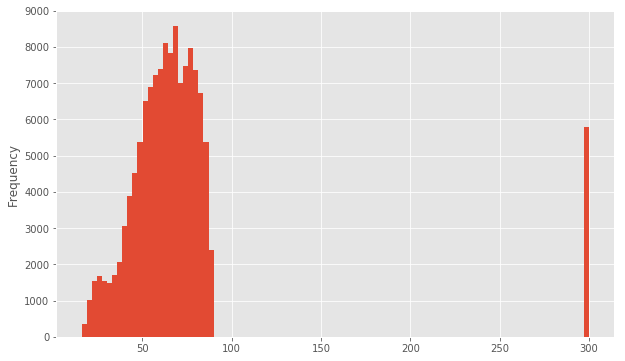

time: 492 ms


In [18]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul['first_admit_age'].sort_values(ascending=True).plot.hist(100)

In [11]:
ABrx_16sterile_ntnul.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,ICU_admit,ICU_disch,los,first_wardid,last_wardid,chartdate,culture_charttime,spec_itemid,spec_type_desc,org_name
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
1,842,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
2,59177,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
3,59181,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
4,60474,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None


time: 21.9 ms


### annotating pt who have antibiotics data in cv, mv, or both. 

In [12]:
# updated 4/11/18  
cv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='carevue']['subject_id'].unique()
mv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='metavision']['subject_id'].unique()

both_pts= []
for pt in ABrx_16sterile_ntnul["subject_id"].unique():
    if pt in cv_pts and pt in mv_pts:
        both_pts.append(pt)
        
#need to annotate in pt_db_association column
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='carevue','pt_ab_db']='cv_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='metavision','pt_ab_db']='mv_ab'
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='both','pt_ab_db']='both_marking_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id'].isin(both_pts),'pt_ab_db']='cv/mv_ab'


ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul.sort_values('startdate').drop_duplicates('subject_id')
ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul_pts[['subject_id','Antibiotics','dob','gender','first_admit_age','pt_ab_db']]
#pt_ab_age_df = pd.merge(pt_sterile16_list, ABrx_merged_16sterile_ntnul_pts[['subject_id','pt_ab_db']], left_on= 'subject_id', right_on='subject_id',how = 'inner') 

ABrx_16sterile_ntnul_pts['pt_ab_db'].value_counts() #total: 14903

#numbers before regenerating dataset (filtered for only culture dates within icu date windows -> pt has any sterile culture)
# cv_ab              10394 -> 9639 -> 9658
# mv_ab               9993 -> 9243 -> 9247
# cv/mv_ab             777 -> 684 -> 683
# both_marking_ab       72 -> 72 -> 72


cv_ab              9658
mv_ab              9247
cv/mv_ab            683
both_marking_ab      72
Name: pt_ab_db, dtype: int64

time: 804 ms


### restricting db to only 24hr associated AB and SC
- marking first ab date within 24hr of sterile site culture
- restricting to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
- note: the t_end consec is established in the next set to determine consecutive ab days.

In [13]:
def AB_SC_associated_time_annotation(ABrx_16sterile_ntnul):
    """
    fxn: annotates antibiotic dataframe with t_0 and t_end for each patient.
    ##t0 is the first ab date in icu associated within 24 hours of sterile site culture
    ##t_end is the longest duration ab associated with t0
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture. 
    """
    
    #boolean criteria where delta between the AB startdate and culture_charttime is less than 24hr
    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'

    #column annotating the delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_16sterile_ntnul['ab_culture_delta'] = (
        pd.to_datetime(ABrx_16sterile_ntnul['startdate']) 
        - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
    )

    #df of all rows where delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]
    
    #annotating t_0: the first ab date in icustay associated within 24 hours of sterile site culture
    ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))

    
    ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

    ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
        ABrx_ab24hrdelta['startdate']==ABrx_ab24hrdelta[
            't_0']].sort_values(
                ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')


    #adding t_0 and t_end to ABrx_16sterile_ntnul by merging w/ AB24startdate and enddate above
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24startdate,
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24enddate[['icustay_id','enddate']],
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    #renaming columns for ease
    ABrx_16sterile_ntnul=(
        ABrx_16sterile_ntnul.rename(index=str, columns={'enddate_x':'enddate',"enddate_y":"t_end"})
    )
    return(ABrx_16sterile_ntnul)


def AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul):
    """
    fxn: restrict the input dataframe to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output:  ABrx_16sterile_ntnul (updated) annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture.
    
    ABrx_16sterile_ntnul2 (updated) annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture (same as ntnul above) AND filtered to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.
    """
    ABrx_16sterile_ntnul = AB_SC_associated_time_annotation(ABrx_16sterile_ntnul)
    
    ABrx_16sterile_ntnul2=(
        ABrx_16sterile_ntnul.loc[
            ABrx_16sterile_ntnul['startdate'] >= ABrx_16sterile_ntnul['t_0']]
    )
    ABrx_16sterile_ntnul2['t_end_consec']=ABrx_16sterile_ntnul2['t_end']
    ABrx_16sterile_ntnul2['abduration']= (
        pd.to_datetime(ABrx_16sterile_ntnul2['enddate'])
        - pd.to_datetime(ABrx_16sterile_ntnul2['startdate'])
    )

    ABrx_16sterile_ntnul2.sort_values(['subject_id','startdate'])
    return(ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2) #this should be df where all ab_icustart dates are greater than or 
                                  #equal to the first 24 hour associated ab start date after icu admission.

time: 70.1 ms


In [14]:
ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2= AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

time: 4.72 s


In [15]:
ABrx_16sterile_ntnul.head()
len(ABrx_16sterile_ntnul)

130880

time: 2.36 ms


In [16]:
len(ABrx_16sterile_ntnul2)
ABrx_16sterile_ntnul2.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,culture_charttime,spec_itemid,spec_type_desc,org_name,pt_ab_db,ab_culture_delta,t_0,t_end,t_end_consec,abduration
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,27 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,0 days
1,842,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,16 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,25 days
2,59177,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,4 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,3 days
3,59181,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,4 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,12 days
4,60474,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,60 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,3 days


time: 28.2 ms


In [17]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc
@memory.cache
def update_t_end(t):  
    t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'enddate']
    t['t_end_consec']= t.groupby('icustay_id')['t_end_consec'].transform(lambda x: max(x))
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)


time: 9.39 ms


### Calculate and annotate the total continuous time on ANY antibiotic during each patient’s icu stay

In [18]:
def t_end_consec_annotation(ABrx_16sterile_ntnul2):
    """
    input: df, 
    designed for ABrx_16sterile_ntnul2-this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.

    output: ABrx_16sterile_ntnul_final: ABrx_16sterile_ntnul2 with t_start and t_end updated. each antibiotic 
    
    ABrx_16sterile_ntnul_finalPT: final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. 
    said another way, using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 
    """
        
    important_columns=[
        'subject_id',
        'icustay_id',
        'hadm_id', #added 8/14/18
        'drug',
        'culture_charttime',
        'ab_culture_delta',
        'startdate',
        'enddate',
        't_0',
        't_end',
        'abduration',
        't_end_consec',
        'ICU_admit',
        'ICU_disch'
    ]
    ABrx_16sterile_ntnul_final= ABrx_16sterile_ntnul2[important_columns].sort_values( 
        ['subject_id',
         'hadm_id', #added 8/14/18
         'icustay_id',
         'startdate',
         'abduration'], ascending=[True,True, True, False, True])  #added another True 8/14/18
    
    #updating t_end consec by running my update_t_end algorithm 5 times. 
    i=1
    while i<6:
        ABrx_16sterile_ntnul_final= update_t_end(ABrx_16sterile_ntnul_final)
        i+=1
    
    #making a final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_final.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('hadm_id')  #changed subject_id to hadm_id on 8/14/18
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_finalPT.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('icustay_id')  #changed subject_id to hadm_id on 8/14/18
    
    return(ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT)

time: 24.9 ms


In [19]:
ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT= t_end_consec_annotation(ABrx_16sterile_ntnul2)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Persisting input arguments took 1.80s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Persisting input arguments took 1.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
/Users/geickelb1/anaco

time: 44.1 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


count                     15207
mean     5 days 10:25:04.202012
std      5 days 21:11:35.416146
min             0 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             7 days 00:00:00
max            97 days 00:00:00
Name: abduration, dtype: object
2 days    2126
1 days    1995
3 days    1993
4 days    1475
5 days    1241
0 days    1092
6 days    1045
7 days     824
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    3416
Name: abduration, dtype: int64


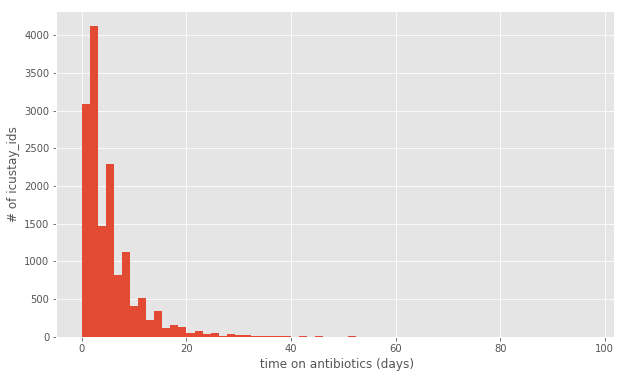

time: 296 ms


In [20]:
#all patients with appropriate antibiotic timing in relation to sterile culture. 
print(ABrx_16sterile_ntnul_finalPT['abduration'].describe())

(ABrx_16sterile_ntnul_finalPT['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))
#4/24: n=12613. 
#7/6/18: n=12611

In [21]:
#ABrx_16sterile_ntnul_finalPT.head()
ABrx_16sterile_ntnul_finalPT.loc[:,'hadm_id'].value_counts().describe()

count    15207.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: hadm_id, dtype: float64

time: 12.6 ms


In [22]:
ABrx_16sterile_ntnul_finalPT.loc[:,'icustay_id'].value_counts().describe()

count    15207.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: icustay_id, dtype: float64

time: 11.4 ms


In [23]:
###08/13/2018 some quick qc to respond to nelson, delete

#goal: need to tell how i get from a "by icu_stayid" to a "by patient" final dataframe. where did i choose between them?

time: 898 µs


# adding in DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [24]:
#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).


list_pt =ABrx_16sterile_ntnul_finalPT['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, DOD_HOSP, DOD_SSN 
from mimiciii.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
#dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

dod_df2= dod_df[dod_df['delta'].notnull()]
dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:]

,subject_id,dod_hosp,dod_ssn,delta
224,1339,2140-02-27,2140-02-28,-1 days
280,1748,2188-07-20,2188-07-18,2 days
288,1787,2117-01-14,2117-01-16,-2 days
378,2228,2187-06-20,2187-06-21,-1 days
395,2349,2165-05-16,2165-05-28,-12 days
423,2570,2115-02-20,2115-02-21,-1 days
470,2809,2131-11-23,2131-11-13,10 days
673,3913,2132-08-19,2132-08-27,-8 days
676,3920,2113-01-30,2113-01-27,3 days
751,4276,2109-09-18,2109-09-15,3 days


time: 153 ms


In [25]:
# categorize pt into ab bins

time: 640 µs


In [26]:
#task 4, categorize every patient into ab bins
# group 1= partial= is antibiotics for 3 days or less
# group 2= full= is antibiotics for 5 or more days or died during ab course

ABrx_16sterile_ntnul_finalPT = pd.merge(
    ABrx_16sterile_ntnul_finalPT,
    dod_df[['subject_id','dod_hosp','dod_ssn']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

ABrx_16sterile_ntnul_finalPT['ab_course']=''

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] <= pd.Timedelta(days=4),'ab_course']='partial' #days changed from 3 to 4 on 7/16/18 based on Nelson's suggestion

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] >= pd.Timedelta(days=5),'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_hosp'])),
    'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_ssn'])),
    'ab_course']='full'

print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='full','subject_id'].unique())) #5485 full patients -> 6188 full on 7/6
print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='partial','subject_id'].unique())) #5949 partial patients -> 5305 partial on 7/6


6885
6734
time: 81.6 ms


In [27]:
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']>= pd.Timedelta(days=8),'abduration'].value_counts(bins=1))

2 days    2126
1 days    1995
3 days    1993
4 days    1475
5 days    1241
0 days    1092
6 days    1045
7 days     824
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    3416
Name: abduration, dtype: int64
time: 20.3 ms


In [28]:
# ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']== pd.Timedelta(days=0),:]

time: 584 µs


In [29]:
ABrx_16sterile_ntnul_finalPT['icustay_id'].nunique() #12611 subject id's, 12611 icustay id's

15207

time: 7.03 ms


# Extracting Sterile Site Culture results
### accounting for all sterile cultures taken within 48 hours of the first ab. 
4/22/18 (overhauled on 1/25/19 for PA project, reapplied 4/3/19)

we now have a by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. these are only for ab's that have a ssc within 24 hours of starting.
for each patient we have the ab start date (t_0)  and the end of the consecutive ab time window (t_end)

In [30]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

time: 1.12 ms


In [31]:
# list(ABrx_16sterile_ntnul)
# ABrx_16sterile_ntnul['subject_id'].nunique()

time: 993 µs


In [32]:
def SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
                   ssc_sql=sterile_pt_df,
                   blood_only=False,
                   n_days=3,
                   n_day_column='t_0_sc',
                   first_ssc_after_ICU=False,
                   filter_t0_after_ICU=False,
                   n_filter_days=4):
    """
    input: ABrx_16sterile_ntnul_finalPT: final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. 
    said another way, using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 
    
    ssc_sql: the primary sql query df for ssc info from mimic (default is to use sterile_pt_df)
  
    blood_only: option to restrict to only blood cultures
    
    n_days, n_day_column: the number of days after t_0 where SSC's will be considered to assign a patient as having a positive or negative.
    origionally the criteria was to find SSC cultures within a 3 days window of t_0 (first ab time) and t_0_sc (first ssc time), if any were pos then patient was culture pos, else negative.
    we can sepcify column (n_day_column) and day window if we want to look from ICU_admit instead.
    
    first_ssc_after_ICU: allows option to restrict the culture result output to only those after ICU admission. 
    filter_t0_after_ICU: allows option to restrict the first antibiotic (t_0) to only those after ICU admission. 
    n_filter_days: number of days allowed after ICU admit for an ab (t_0) to occur for patient to be considered, requires  filter_t0_after_ICU=True.
    
    
    outputs:
    
        all_cultures_pt_df_ab_cohort: all (neg and pos) culture results for patients meeting criteria
        notneg_cultures_pt_df_ab_cohort: just positive culture results for patients meeting criteria
        positive_organisms: all positive organisms found in ssc instances between t_0_sc and n_day_column. 
    """
    
    #option criteria1: to restrict to only blood cultures
    if blood_only == True:
        ssc_sql=(ssc_sql.loc[ssc_sql.loc[:,'spec_type_desc']
                                     .isin(["BLOOD CULTURE",
                                            'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)'])
                                     ,:])
   
    ab_cohort_pt_info = final_abdata_pt_df[['hadm_id','culture_charttime','t_0','ICU_admit','dod_ssn']].copy() #culture charttime is the culture recorded as being within 24 hr of t_0
    
    ##optional criteria2: only patients who started their ab (t_0) within n_filter_days after icu_admit?  -this is to limit to non-2dary infections.
    if filter_t0_after_ICU == True:
        n_filter_days= pd.Timedelta('%s days' %(n_filter_days))
        ab_cohort_pt_info['t0_admit_delta']=pd.to_datetime(ab_cohort_pt_info['t_0']) - pd.to_datetime((ab_cohort_pt_info['ICU_admit']))
        ab_cohort_pt_info = ab_cohort_pt_info[ab_cohort_pt_info['t0_admit_delta']<= n_filter_days]
    
    sterile_pt_df_ab_cohort = pd.merge(ssc_sql,
                                       ab_cohort_pt_info ,
                                       left_on='hadm_id',
                                       right_on='hadm_id',
                                       how='inner' ) #adding ['hadm_id','culture_charttime','t_0','ICU_admit','dod_ssn'] onto the culture results for all patients
    
    #making the Null charttime values = to chartdate
    cd= sterile_pt_df_ab_cohort.loc[sterile_pt_df_ab_cohort.loc[:,'charttime'].isna(),"chartdate"]
    sterile_pt_df_ab_cohort.loc[sterile_pt_df_ab_cohort.loc[:,'charttime'].isna(),"charttime"]= cd
    sterile_pt_df_ab_cohort= sterile_pt_df_ab_cohort.rename(columns={'culture_charttime':'t_0_sc'})
    
    #ensuring columns are in datetime format
    sterile_pt_df_ab_cohort['t_0_sc']= pd.to_datetime(sterile_pt_df_ab_cohort['t_0_sc'])
    sterile_pt_df_ab_cohort['charttime']= pd.to_datetime(sterile_pt_df_ab_cohort['charttime'])
    sterile_pt_df_ab_cohort['ICU_admit']= pd.to_datetime(sterile_pt_df_ab_cohort['ICU_admit'])
    #sterile_pt_df_ab_cohort.groupby('hadm_id')['charttime'].transform(lambda x: min(x))#was used to check that culture_charttime is indeed first sc ab within 24 hr of t_0.
    
    ####filtering criteria for all SSC results:######
    
    #optional criteria3: limiting to only rows where ssc was performed after ICU admit.
    if first_ssc_after_ICU ==True:        
        sterile_pt_df_ab_cohort['ssc_admit_delta']= pd.to_datetime(sterile_pt_df_ab_cohort['charttime']) -pd.to_datetime(sterile_pt_df_ab_cohort['ICU_admit'])
        sterile_pt_df_ab_cohort= sterile_pt_df_ab_cohort[sterile_pt_df_ab_cohort['ssc_admit_delta']>pd.Timedelta('0 days')] #only rows where culture occured in icu. 
    
    
    #criteria1: only results at or after the first positive within 24 hr of t_0
    criteria1= sterile_pt_df_ab_cohort['charttime']>=sterile_pt_df_ab_cohort['t_0_sc'] #t_0_scis the first ssc within 24 hr of t_0
    
    #criteria2: only results within n_days of n_day_column
    t_window= pd.Timedelta('%s days' %(n_days))
    criteria2= (sterile_pt_df_ab_cohort['charttime'])<=(sterile_pt_df_ab_cohort[n_day_column]+ t_window) #ensure it's within n_days of n_day_column (default = culture_chartime, but can switch to t_admit)

    
    all_cultures_pt_df_ab_cohort = sterile_pt_df_ab_cohort[criteria1 & criteria2].drop_duplicates(['hadm_id', 'org_name', 'charttime'])
    notneg_cultures_pt_df_ab_cohort= all_cultures_pt_df_ab_cohort[all_cultures_pt_df_ab_cohort['org_name'].notnull()].sort_values(['hadm_id','charttime'], ascending=[True, False]) #16022 rows... 6619 hadm_id
    positive_organisms= notneg_cultures_pt_df_ab_cohort['org_name'].value_counts()
    
    
    final_pt_df= all_cultures_pt_df_ab_cohort[['subject_id','hadm_id','t_0_sc']] 
       
    return(all_cultures_pt_df_ab_cohort,notneg_cultures_pt_df_ab_cohort,positive_organisms, final_pt_df)

time: 123 ms


In [33]:
#for origional cohort:

# all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
#                                                                                                    ssc_sql=sterile_pt_df,
#                                                                                                    blood_only=False,
#                                                                                                    n_days=3,
#                                                                                                   n_day_column='t_0_sc',
#                                                                                                   first_ssc_after_ICU=False)


#for origional cohort adjusted 4-4-19:

all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
                                                                                                   ssc_sql=sterile_pt_df,
                                                                                                   blood_only=False,
                                                                                                   n_days=3,
                                                                                                   n_day_column='t_0_sc',
                                                                                                   first_ssc_after_ICU=False,
                                                                                                   filter_t0_after_ICU=True,
                                                                                                   n_filter_days=4)

# #for PAII cohort:
# all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
#                                                                                                    ssc_sql=sterile_pt_df,
#                                                                                                    blood_only=True,
#                                                                                                    n_days=3,
#                                                                                                   n_day_column='t_0_sc',
#                                                                                                   first_ssc_after_ICU=True,
#                                                                                                   filter_t0_after_icu=True,
#                                                                                                    n_filter_days=4)

time: 202 ms


In [34]:


# #1) first define the 24 hour associated ab- t_0_sc. 
# #2) define 48 hour after the ab- t_end_sc
# #filter list of all sterile cultures on the above icustay_id and dates
# #record for each icustay_id if any of cultures within the timeframe are positive

# #this reuses a lot of the same code used previously in AB_SC_associated_time_annotation. I'm sure this could be optimized/simplified but it works currently. 

# def pt_sc_results(ABrx_16sterile_ntnul):

#     lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
#         ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'
#     ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]

#     #ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x)) #8/16/18: do i actually need this? haven't i done this already?

#     ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
#     ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=3) #changed from 2 to 3 on 1/21/19

#     #filtering it to only essential info, and only for patients who made it through all other criteria. 
#     patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
    
#     #filtering to only pt in ABrx_16sterile_ntnul_finalPT
#     patients_sc_dates= patients_sc_dates.loc[
#         patients_sc_dates.loc[:,'icustay_id'].isin(
#             list(ABrx_16sterile_ntnul_finalPT['icustay_id'].unique())),:
#     ] 
    
#     final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
#     final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']], left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

#     pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])

#     #all sterile site culture instances between t_0_sc and t_end_sc for patients     
#     final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
#                     (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
#                     final_pts_all_sc['org_name'].notnull()] 


#     positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
#                     (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
#                     final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()
    
#     return(patients_sc_dates, final_pts_window_sc, positive_organisms)

time: 15.6 ms


In [35]:
all_cultures_pt_df_ab_cohort #50556 ->49040 (filter_t0_after_icu) -> 33149 (filter t_0 and ssc after icu)

,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_name,t_0_sc,t_0,ICU_admit,dod_ssn,t0_admit_delta
0,42319,3301,194119,2116-06-27,2116-06-27 00:00:00,70079,URINE,None,2116-06-27 00:00:00,2116-06-28,2116-06-26 20:05:51,NaT,1 days 03:54:09
2,42141,3281,113868,2115-09-14,2115-09-14 19:25:00,70012,BLOOD CULTURE,None,2115-09-14 19:25:00,2115-09-14,2115-09-13 23:16:50,2116-03-06,0 days 00:43:10
21,42099,3277,163302,2123-07-24,2123-07-24 09:30:00,70012,BLOOD CULTURE,None,2123-07-24 09:30:00,2123-07-24,2123-07-21 13:04:46,NaT,2 days 10:55:14
29,42089,3276,111860,2168-08-31,2168-08-31 00:00:00,70012,BLOOD CULTURE,None,2168-08-31 00:00:00,2168-08-30,2168-08-26 21:21:59,NaT,3 days 02:38:01
30,42088,3276,111860,2168-08-31,2168-08-31 22:40:00,70079,URINE,None,2168-08-31 00:00:00,2168-08-30,2168-08-26 21:21:59,NaT,3 days 02:38:01
31,42087,3276,111860,2168-08-31,2168-08-31 21:21:00,70012,BLOOD CULTURE,None,2168-08-31 00:00:00,2168-08-30,2168-08-26 21:21:59,NaT,3 days 02:38:01
38,41971,3272,105931,2114-11-20,2114-11-20 15:50:00,70079,URINE,None,2114-11-20 15:50:00,2114-11-21,2114-11-20 19:51:15,2117-02-14,0 days 04:08:45
41,41945,3267,134370,2193-08-28,2193-08-28 09:30:00,70012,BLOOD CULTURE,None,2193-08-28 09:30:00,2193-08-28,2193-08-26 12:28:29,2193-08-28,1 days 11:31:31
73,41684,3266,156533,2137-04-03,2137-04-03 23:30:00,70012,BLOOD CULTURE,None,2137-04-03 23:30:00,2137-04-04,2137-03-31 12:04:38,2142-03-15,3 days 11:55:22
88,41300,3248,155346,2169-10-08,2169-10-08 05:00:00,70012,BLOOD CULTURE,None,2169-10-08 05:00:00,2169-10-08,2169-10-08 01:34:56,2169-10-10,-1 days +22:25:04


time: 46.7 ms


In [36]:
# patients_sc_dates, final_pts_window_sc, positive_organisms = pt_sc_results(ABrx_16sterile_ntnul)

time: 837 µs


# SC culture filtering and ab death dose adjust

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.

08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.




In [37]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
notneg_cultures_pt_df_ab_cohort= pd.merge(notneg_cultures_pt_df_ab_cohort,annotated_sc[['org_name','Eliminate']],
                              left_on= 'org_name',
                              right_on='org_name',
                              how = 'left')



time: 34.2 ms


In [38]:
##4-4-19: changed to the much cleaner version written in the PA project.
def sc_pos_filter(notneg_cultures_pt_df_ab_cohort):
    #coag_neg_staph_counting:
    staph_cultures= notneg_cultures_pt_df_ab_cohort.loc[notneg_cultures_pt_df_ab_cohort.loc[:,'Eliminate']==2,:].drop_duplicates(['hadm_id', 'org_name', 'charttime'])

    staph_count = staph_cultures.groupby('hadm_id')['hadm_id'].agg(["count"]).rename(columns={'count': 'staph_count'})
    staph_count= pd.DataFrame(staph_count).reset_index()

    merged = pd.merge(
        notneg_cultures_pt_df_ab_cohort,
        staph_count, #changed  subject_id to hadm_id 08/16/2018
        left_on= 'hadm_id', #changed  subject_id to hadm_id 08/16/2018
        right_on='hadm_id', #changed  subject_id to hadm_id 08/16/2018
        how = 'left')

    #combining staph, positive org and neg org criteria to make only positive org list. 
    criteria1= merged.loc[:,'Eliminate']==0
    criteria2= merged.loc[:,'staph_count']>1
    merged= merged[criteria1|criteria2] #all unique values betwen the two
    merged= merged[merged['Eliminate']!=1] #eliminate =1 means to get rid of culture result, ie likely contamination
    #merged
    return(merged)

pos_cultures_pt_df_ab_cohort = sc_pos_filter(notneg_cultures_pt_df_ab_cohort) #31108 #all pos sc for patients with any positives.
pos_cultures_pt_df_ab_cohort= pos_cultures_pt_df_ab_cohort.drop_duplicates(['hadm_id', 'org_name', 'charttime']) #removing duplicates, not sure why dups exist

pos_cultures_pt_df_ab_cohort_list= list(pos_cultures_pt_df_ab_cohort['hadm_id'].unique()) #changed to hadm_id 08/16/2018

# ######origional. changed  final_pts_window_pos_sc->pos_cultures_pt_df_ab_cohort
# final_pts_window_pos_sc = sc_pos_filter(final_pts_window_sc) #31108 #all sc for patients with any positives.
# final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['hadm_id'].unique()) #changed to hadm_id 08/16/2018
# #len(final_pts_window_pos_sc_list) #2630. 

time: 73.3 ms


In [39]:
# final_pts_window_pos_sc.loc[final_pts_window_pos_sc.loc[:,'staph_pos_count']>2,:].head()
# #hadm_id 183885 has positive staph
pos_cultures_pt_df_ab_cohort.sort_values(['hadm_id', 'org_name', 'charttime']).head(10)

,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_name,t_0_sc,t_0,ICU_admit,dod_ssn,t0_admit_delta,Eliminate,staph_count
0,6915,533,100009,2162-05-16,2162-05-16 21:10:00,70079,URINE,BETA STREPTOCOCCUS GROUP B,2162-05-16 21:10:00,2162-05-17,2162-05-17 10:18:31,NaT,-1 days +13:41:29,0.0,NaN
4,489834,58240,100113,2153-01-05,2153-01-05 15:04:00,70053,PERITONEAL FLUID,ESCHERICHIA COLI,2153-01-05 15:04:00,2153-01-05,2153-01-05 00:36:39,NaT,-1 days +23:23:21,0.0,NaN
3,489859,58240,100113,2153-01-06,2153-01-06 00:00:00,70079,URINE,ESCHERICHIA COLI,2153-01-05 15:04:00,2153-01-05,2153-01-05 00:36:39,NaT,-1 days +23:23:21,0.0,NaN
5,489840,58240,100113,2153-01-05,2153-01-05 15:04:00,70053,PERITONEAL FLUID,GRAM POSITIVE RODS,2153-01-05 15:04:00,2153-01-05,2153-01-05 00:36:39,NaT,-1 days +23:23:21,0.0,NaN
7,189820,14297,100117,2166-04-30,2166-04-30 17:00:00,70012,BLOOD CULTURE,STREPTOCOCCUS PNEUMONIAE,2166-04-30 17:00:00,2166-05-01,2166-04-30 20:14:40,NaT,03:45:20,0.0,NaN
6,189825,14297,100117,2166-04-30,2166-04-30 17:10:00,70012,BLOOD CULTURE,STREPTOCOCCUS PNEUMONIAE,2166-04-30 17:00:00,2166-05-01,2166-04-30 20:14:40,NaT,03:45:20,0.0,NaN
9,247221,18604,100142,2171-08-17,2171-08-17 19:07:00,70079,URINE,ESCHERICHIA COLI,2171-08-17 18:48:00,2171-08-18,2171-08-17 21:46:24,NaT,02:13:36,0.0,NaN
13,90266,6741,100191,2146-11-17,2146-11-17 19:30:00,70079,URINE,ENTEROBACTERIACEAE,2146-11-17 19:30:00,2146-11-18,2146-11-17 23:09:22,2153-12-20,00:50:38,0.0,1.0
11,90249,6741,100191,2146-11-17,2146-11-17 19:30:00,70079,URINE,KLEBSIELLA PNEUMONIAE,2146-11-17 19:30:00,2146-11-18,2146-11-17 23:09:22,2153-12-20,00:50:38,0.0,1.0
10,90293,6741,100191,2146-11-18,2146-11-18 13:58:00,70012,BLOOD CULTURE,KLEBSIELLA PNEUMONIAE,2146-11-17 19:30:00,2146-11-18,2146-11-17 23:09:22,2153-12-20,00:50:38,0.0,1.0


time: 29.1 ms


### make list of all patients positive, negative sc cultures

In [40]:
##4-4-19: changed to the much cleaner version written in the PA project.

#5/2/18, makes list of all pos culture result and specimen types for annotation on final df
#organism name

# pos_cultures_pt_df_ab_cohort2 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['Gram_pos'].apply(lambda x: min(x)).reset_index()

pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['org_name'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort3.rename(index=str, columns={'org_name':'org_list'})

#specimen type
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['spec_type_desc'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types


# #5/2/18, makes list of all pos culture result and specimen types for annotation on final df
# def sc_pos_filter2(final_pts_window_sc):
#     final_pts_window_sc['concat_col']=(
#         final_pts_window_sc['hadm_id'].map(str)  #changed to hadm_id 08/16/2018
#         + ' ' 
#         + final_pts_window_sc['org_name'].map(str) 
#         + ' ' 
#         +  final_pts_window_sc['chartdate'].map(str)
#     )
#     final_pts_window_sc2= final_pts_window_sc.drop_duplicates('concat_col') #n=1603

#     return(final_pts_window_sc2)

# final_pts_window_pos_sc2 = sc_pos_filter2(final_pts_window_pos_sc) #31108 #all sc for patients with any positives.
# #organism name
# final_pts_window_pos_sc3 = final_pts_window_pos_sc2.groupby('hadm_id')['org_name'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
# final_pts_window_pos_sc3 = final_pts_window_pos_sc3.rename(index=str, columns={'org_name':'org_list'})

# #specimen type
# final_pts_window_pos_sc4 = final_pts_window_pos_sc2.groupby('hadm_id')['spec_type_desc'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
# final_pts_window_pos_sc4 = final_pts_window_pos_sc4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

# #now have a column with all positive culture results and specimen types


time: 572 ms


In [41]:
#first dates for positive culture within criteria window, else first culture within criteria window.
first_criteria_pos_culture= pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['charttime'].apply(lambda x: min(x)).reset_index()
first_criteria_any_culture= all_cultures_pt_df_ab_cohort.groupby('hadm_id')['charttime'].apply(lambda x: min(x)).reset_index()

first_criteria_pos_culture= first_criteria_pos_culture.rename(index=str, columns={'charttime':'pos_charttime'})
first_criteria_any_culture= pd.merge(first_criteria_any_culture, first_criteria_pos_culture, left_on='hadm_id', right_on='hadm_id', how='left')
first_criteria_any_culture['first_pos_else_neg_ssc']= first_criteria_any_culture['pos_charttime']
neg_else = first_criteria_any_culture['first_pos_else_neg_ssc'].isnull()
first_criteria_any_culture.loc[neg_else, 'first_pos_else_neg_ssc'] = first_criteria_any_culture.loc[neg_else, 'charttime']
first_criteria_any_culture=first_criteria_any_culture[['hadm_id','first_pos_else_neg_ssc']]

time: 1.56 s


In [42]:
#len(patients_sc_dates) #15207

time: 584 µs


## this is final patient dataframe with n patients with following criteria:
* antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
* who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
* also annotated on this. these patients were then categorized into 4 categories:
 * 'C_neg/A_partial'
 * 'C_neg/A_full'
 * 'C_pos/A_full'
 * 'C_pos/A_partial'
#### notes:
* 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

* 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 

* 3) time window for positive culture is defined in SSC_for_cohort (default 72hr from t_0_sc)



##### pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv') #date may change

In [43]:
final_pt_df=0
final_pt_df = final_pt_df1#all_cultures_pt_df_ab_cohort[['subject_id','hadm_id','t_0_sc']]  #needs icustay_id

final_pt_df = pd.merge(
    final_pt_df,
    ABrx_16sterile_ntnul_finalPT[['hadm_id','icustay_id','ab_course', 't_0','t_end_consec','ICU_admit']], #testing the ICU_admit with this
    left_on= 'hadm_id', #changed from subject_id
    right_on='hadm_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort3,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort4,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    first_criteria_any_culture,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'hadm_id'].isin(pos_cultures_pt_df_ab_cohort_list),'sc_result']='positive' #changed to hadm_id from subject_id 08/16/18
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

#FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:].drop_duplicates('hadm_id')

time: 296 ms


In [44]:
#pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv')


time: 565 µs


In [45]:
final_pt_df2['icustay_id'].nunique() #15207 ->14668 after restricting ab to be within icu.
final_pt_df2['subject_id'].nunique() #15207 ->14668 after restricting ab to be within icu.

12345

time: 12.4 ms


In [46]:
print(final_pt_df2['final_bin'].value_counts())

C_neg/A_partial    5798
C_neg/A_full       5263
C_pos/A_full       2073
C_pos/A_partial    1534
Name: final_bin, dtype: int64
time: 11.4 ms


In [47]:
final_pt_df2

,subject_id,hadm_id,t_0_sc,icustay_id,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin
0,3301,194119,2116-06-27 00:00:00,222957.0,full,2116-06-28,2116-06-28,2116-06-26 20:05:51,NaT,NaT,NaT,NaN,NaN,2116-06-27 00:00:00,negative,C_neg/A_full
1,3281,113868,2115-09-14 19:25:00,240363.0,partial,2115-09-14,2115-09-16,2115-09-13 23:16:50,2116-03-06,2116-03-06,0 days,NaN,NaN,2115-09-14 19:25:00,negative,C_neg/A_partial
2,3277,163302,2123-07-24 09:30:00,220265.0,full,2123-07-24,2123-08-06,2123-07-21 13:04:46,NaT,NaT,NaT,NaN,NaN,2123-07-24 09:30:00,negative,C_neg/A_full
3,3276,111860,2168-08-31 00:00:00,224362.0,partial,2168-08-30,2168-08-30,2168-08-26 21:21:59,NaT,NaT,NaT,NaN,NaN,2168-08-31 00:00:00,negative,C_neg/A_partial
6,3272,105931,2114-11-20 15:50:00,296728.0,partial,2114-11-21,2114-11-23,2114-11-20 19:51:15,NaT,NaT,NaT,NaN,NaN,2114-11-20 15:50:00,negative,C_neg/A_partial
7,3267,134370,2193-08-28 09:30:00,278829.0,full,2193-08-28,2193-08-28,2193-08-26 12:28:29,2193-08-28,2193-08-28,0 days,NaN,NaN,2193-08-28 09:30:00,negative,C_neg/A_full
8,3266,156533,2137-04-03 23:30:00,271485.0,partial,2137-04-04,2137-04-04,2137-03-31 12:04:38,NaT,NaT,NaT,NaN,NaN,2137-04-03 23:30:00,negative,C_neg/A_partial
9,3248,155346,2169-10-08 05:00:00,206821.0,full,2169-10-08,2169-10-09,2169-10-08 01:34:56,2169-10-10,2169-10-10,0 days,NaN,NaN,2169-10-08 05:00:00,negative,C_neg/A_full
10,3239,155197,2130-07-19 23:56:00,257253.0,partial,2130-07-20,2130-07-24,2130-07-20 05:02:52,NaT,NaT,NaT,NaN,NaN,2130-07-19 23:56:00,negative,C_neg/A_partial
11,3232,146611,2150-04-06 08:15:00,275841.0,full,2150-04-06,2150-04-08,2150-04-06 11:24:00,NaT,NaT,NaT,GRAM POSITIVE BACTERIA,URINE,2150-04-06 08:15:00,positive,C_pos/A_full


time: 51.3 ms


# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [48]:
# #5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
# #breakdown the 1345 pts cultures, 
# #if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
# #more informative to know if pt was ever pos for bloodculture.

# #Look at distribution of all cultures within the 24 hour mark. 

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

time: 1.69 ms


# compiling the dataframes into csv's

In [56]:
date='04042019'

pd.DataFrame(final_pt_df2).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18) -> 12345 4/4/19.


time: 270 ms


style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.

In [50]:
#last instance of ICU_admit time. 

time: 774 µs


In [51]:
#final_pt_df2

time: 411 µs


In [57]:
(pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0'])).describe()
#good, as intended no t_0 occur before ICU admit. 

count                       14668
mean     -1 days +17:09:38.813471
std        0 days 17:36:23.008583
min             -4 days +00:13:53
25%      -1 days +15:57:23.750000
50%             -1 days +21:03:55
75%        0 days 02:12:00.250000
max               0 days 11:59:39
dtype: object

time: 48.4 ms


In [58]:
final_pt_df2['admit_vs_t_0']= (pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0']))

time: 41.4 ms


In [59]:
final_pt_df2['admit_vs_t_0_td']=final_pt_df2['admit_vs_t_0'].astype(np.timedelta64)

time: 2.13 ms


In [60]:
final_pt_df2.sort_values('admit_vs_t_0_td')
final_pt_df2[final_pt_df2['admit_vs_t_0_td']<-1e+14].sort_values('admit_vs_t_0_td')['subject_id'].nunique() #3519/11488 patients have a delta of greater than 2 days of their icustay

1440

time: 13.2 ms


In [58]:
##cohort numbers
s1={'n':(61532,38597,26020,14478),
    'labels': ('MIMICIII ICUStay_id', 'has SSC, >16yo','has ABrx', 'Final Study Criteria')#,
    #'subnum': ()
   }

pd.DataFrame(s1)

,n,labels
0,61532,MIMICIII ICUStay_id
1,38597,"has SSC, >16yo"
2,26020,has ABrx
3,14478,Final Study Criteria


time: 9.64 ms


##cohort numbers
-1	0	38597	purple	MIMICIII ICUstay_id
0	1	38597	purple	has SSC, >16yo
1	2	27315	purple	has ABrx
2	3	14478	purple	final
3	4	5723	green	C_neg/A_partial
3	5	2042	green	C_pos/A_full
3	6	5206	orange	C_neg/A_full
3	7	1507	orange	C_pos/A_partial